In [1]:
from torchvision.models import resnet50
from torchvision.datasets import CIFAR10
from torchvision import transforms
from copy import deepcopy
from math import inf
from google.colab import files
from google.colab import drive
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import gc

In [2]:
class Settings:
  @classmethod
  def engine(cls):
    # Called only to prevent the PyTorch to split the dataset in a different
    # manner each time.
    torch.manual_seed(42)

  # Number of samples chosen uniformly at random from validation (test) set
  # to purturb the model further on. Originally, it was set to 128 in all experiments (K=128).
  random_ensemble_samples = 128
  assert random_ensemble_samples == 128

  # Number of models in the final ensemble (S = [15, 30])
  ensemble_count = 30
  assert ensemble_count in [15, 30]

  validation_percentage = 1 / 5
  assert validation_percentage <= 1 / 2

  # ResNet50 classifier train epoch count
  training_epochs     = 25

  #ResNet50 whole train epoch count
  cnn_training_epochs = 5

  learning_rate = 0.01
  batch_size = 2048

Settings.engine()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
base_model = resnet50(pretrained=True)

base_model.fc = torch.nn.Linear(
  base_model.fc.in_features,
  10
)

# Freeze convolutional layers for fine-tunning, however when making the ensemble we
# send them back in business.
for param in base_model.parameters():
  param.requires_grad = False

# Allow the classifier to be trained
for param in base_model.fc.parameters():
  param.requires_grad = True

base_model = base_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5),
    )
])

train_dataset = CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

test_dataset_size = len(test_dataset)
validation_dataset_size = int(test_dataset_size * Settings.validation_percentage)
test_dataset_size = test_dataset_size - validation_dataset_size

validation_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [validation_dataset_size, test_dataset_size])

len(train_dataset), len(test_dataset), len(validation_dataset)

100%|██████████| 170498071/170498071 [00:12<00:00, 13228180.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


(50000, 8000, 2000)

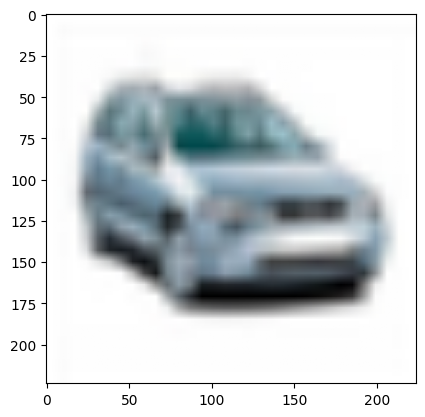

In [5]:
# Make sure the very same image is shown after running the cell
# since we need to have consistent test, train, and validation
# datasets.

image = test_dataset[100][0]
image = image / 2 + 0.5
image = np.transpose(image, (1, 2, 0))

plt.imshow(image)
plt.show()

# Fine-Tunning ResNet50 On CIFAR10

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=Settings.batch_size, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size=Settings.batch_size, shuffle=False)

In [22]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    base_model.parameters(),
    lr=Settings.learning_rate
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=10)

best_model = None
best_accuracy = -inf

NameError: name 'base_model' is not defined

In [8]:
for epoch in range(Settings.training_epochs):
  base_model.train()
  training_loss = 0.0

  for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    predictions = base_model(images)
    loss = criterion(predictions, labels)
    loss.backward()
    optimizer.step()
    training_loss += loss.item()

  # Evaluate the model at the end of each epoch

  base_model.eval()
  test_loss = 0
  correct = 0
  with torch.inference_mode():
    for images, labels in test_dataloader:
      images, labels = images.to(device), labels.to(device)
      test_predictions = base_model(images)
      batch_loss = criterion(test_predictions, labels)
      test_loss += batch_loss.item()
      _, test_predictions = torch.max(test_predictions, 1)
      correct += (test_predictions == labels).float().sum()

  accuracy = 100 * correct / len(test_dataset)

  # Save the best model based on the accuracy on the test images

  if accuracy > best_accuracy:
    best_model = deepcopy(base_model)
    best_accuracy = accuracy

  scheduler.step()
  print(f"Epoch number {epoch + 1}: loss={training_loss} test_loss={test_loss} accuracy={accuracy} lr={scheduler.get_last_lr()}.")

filename = "resnet50-CIFAR10-classifier-only-25epochs-lr0.0001.model"
torch.save(best_model.state_dict(), f"./{filename}")
files.download(f"./{filename}")

Epoch number 1: loss=133.51228964328766 test_loss=4.343904972076416 accuracy=63.92500305175781 lr=[0.01].
Epoch number 2: loss=25.55934715270996 test_loss=2.8001819252967834 accuracy=76.60000610351562 lr=[0.01].
Epoch number 3: loss=16.473407328128815 test_loss=2.451463282108307 accuracy=78.88750457763672 lr=[0.01].
Epoch number 4: loss=14.909898340702057 test_loss=2.3284724354743958 accuracy=79.42500305175781 lr=[0.01].
Epoch number 5: loss=14.170224726200104 test_loss=2.292621433734894 accuracy=79.6500015258789 lr=[0.01].
Epoch number 6: loss=13.801246643066406 test_loss=2.2342451214790344 accuracy=80.66250610351562 lr=[0.01].
Epoch number 7: loss=13.530014038085938 test_loss=2.2199811339378357 accuracy=80.61250305175781 lr=[0.01].
Epoch number 8: loss=13.313354283571243 test_loss=2.1899651288986206 accuracy=81.22500610351562 lr=[0.01].
Epoch number 9: loss=13.103562593460083 test_loss=2.136619210243225 accuracy=81.53750610351562 lr=[0.01].
Epoch number 10: loss=12.805623859167099 te

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Creating The Ensemble

In [6]:
# The previous block contains the information about the latest leraning rate of
# the training phase. You need to copy the learning rate of the latest epoch and
# the rest of the code will use it to purturb the net even further.

ensemble_learning_rate = 0.0001
assert ensemble_learning_rate is not None

In [10]:
# Following code is used for loading a model from a file

filename = "resnet50-CIFAR10-classifier-only-25epochs-lr0.0001.model"
file_location = f"/content/drive/MyDrive/{filename}"

best_model    = resnet50(pretrained=False)
best_model.fc = torch.nn.Linear(
  best_model.fc.in_features,
  10
)
best_model.load_state_dict(torch.load(file_location))
best_model.to(device)

for param in best_model.parameters():
  param.requires_grad = True

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=ensemble_learning_rate
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-10-874215b81b28>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

In [11]:
# Batch sizes have been adapted to the Google Colab A100 GPU (High RAM)
# they need to be modified when run on different hardware architectures
# With CNN layers:    384
# Without CNN layers: 2048

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128 * 3, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size=128 * 3, shuffle=False)

for epoch in range(Settings.cnn_training_epochs):
  best_model.train()
  training_loss = 0.0

  for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    predictions = best_model(images)
    loss = criterion(predictions, labels)
    loss.backward()
    optimizer.step()
    training_loss += loss.item()

  best_model.eval()
  test_loss = 0
  correct = 0

  with torch.inference_mode():
    for images, labels in test_dataloader:
      images, labels = images.to(device), labels.to(device)
      test_predictions = best_model(images)
      batch_loss = criterion(test_predictions, labels)
      test_loss += batch_loss.item()
      _, test_predictions = torch.max(test_predictions, 1)
      correct += (test_predictions == labels).float().sum()

  accuracy = 100 * correct / len(test_dataset)
  print(f"Epoch number {epoch + 1}: loss={training_loss} test_loss={test_loss} accuracy={accuracy}.")

Epoch number 1: loss=26.992843873798847 test_loss=3.336669184267521 accuracy=94.38750457763672.
Epoch number 2: loss=4.402020330540836 test_loss=3.361543171107769 accuracy=95.0250015258789.
Epoch number 3: loss=1.6605308568105102 test_loss=3.653236046433449 accuracy=95.37500762939453.
Epoch number 4: loss=0.7466570212855004 test_loss=3.81483793258667 accuracy=95.42500305175781.
Epoch number 5: loss=1.6766885639517568 test_loss=4.9823242649436 accuracy=93.86250305175781.


In [12]:
filename = "resnet50-CIFAR10-CNN-5epochs-lr0.0001.model"
torch.save(best_model.state_dict(), f"./{filename}")
files.download(f"./{filename}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
models = []

for _ in range(Settings.ensemble_count):
  copied_model = deepcopy(best_model)

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(copied_model.parameters(), lr=ensemble_learning_rate)

  indices = random.sample(range(len(validation_dataset)), Settings.random_ensemble_samples)
  batch   = torch.utils.data.Subset(validation_dataset, indices)
  batch   = torch.utils.data.DataLoader(batch, batch_size=384, shuffle=False)

  copied_model.train()

  for images, labels in batch:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    predictions = copied_model(images)
    loss = criterion(predictions, labels)
    loss.backward()
    optimizer.step()

  copied_model.eval()
  test_loss = 0
  correct = 0
  with torch.inference_mode():
    for images, labels in test_dataloader:
      images, labels = images.to(device), labels.to(device)
      test_predictions = copied_model(images)
      batch_loss = criterion(test_predictions, labels)
      test_loss += batch_loss.item()
      _, test_predictions = torch.max(test_predictions, 1)
      correct += (test_predictions == labels).float().sum()

  accuracy = 100 * correct / len(test_dataset)
  models.append(copied_model)
  print(f"A model with test accuracy of {accuracy} was added to the ensemble.")

A model with test accuracy of 93.86250305175781 was added to the ensemble.
A model with test accuracy of 94.2125015258789 was added to the ensemble.
A model with test accuracy of 93.5250015258789 was added to the ensemble.
A model with test accuracy of 93.31250762939453 was added to the ensemble.
A model with test accuracy of 93.62500762939453 was added to the ensemble.
A model with test accuracy of 93.11250305175781 was added to the ensemble.
A model with test accuracy of 94.13750457763672 was added to the ensemble.
A model with test accuracy of 93.93750762939453 was added to the ensemble.
A model with test accuracy of 93.38750457763672 was added to the ensemble.
A model with test accuracy of 93.11250305175781 was added to the ensemble.
A model with test accuracy of 93.7750015258789 was added to the ensemble.
A model with test accuracy of 93.80000305175781 was added to the ensemble.
A model with test accuracy of 93.7125015258789 was added to the ensemble.
A model with test accuracy of

In [14]:
!mkdir ensemble

In [15]:
for i, model in enumerate(models):
  torch.save(model.state_dict(), f"./ensemble/model-{i}.model")

In [16]:
!zip -r ./ensemble.zip ./ensemble

  adding: ensemble/ (stored 0%)
  adding: ensemble/model-4.model (deflated 7%)
  adding: ensemble/model-11.model (deflated 7%)
  adding: ensemble/model-29.model (deflated 7%)
  adding: ensemble/model-27.model (deflated 7%)
  adding: ensemble/model-26.model (deflated 7%)
  adding: ensemble/model-12.model (deflated 7%)
  adding: ensemble/model-7.model (deflated 7%)
  adding: ensemble/model-20.model (deflated 7%)
  adding: ensemble/model-18.model (deflated 7%)
  adding: ensemble/model-9.model (deflated 7%)
  adding: ensemble/model-19.model (deflated 7%)
  adding: ensemble/model-14.model (deflated 7%)
  adding: ensemble/model-25.model (deflated 7%)
  adding: ensemble/model-5.model (deflated 7%)
  adding: ensemble/model-22.model (deflated 7%)
  adding: ensemble/model-21.model (deflated 7%)
  adding: ensemble/model-28.model (deflated 7%)
  adding: ensemble/model-6.model (deflated 7%)
  adding: ensemble/model-23.model (deflated 7%)
  adding: ensemble/model-8.model (deflated 7%)
  adding: ense

In [17]:
!cp ./ensemble.zip /content/drive/MyDrive